# Importing Libraries, Data and Support Functions

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "psdata/"

In [4]:
!ls {PATH}

Bank Statement.csv


In [5]:
data = pd.read_csv(f'{PATH}Bank Statement.csv')

## Creating support Functions

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
?display()

In [8]:
def clean_col(inputlst):
    col_list = []
    for col in inputlst:
        col = col.strip()
        col = col.lower()
        col = col.replace(" ", "_")
        col = col.replace("(", "")
        col = col.replace(")", "")
        col = col.strip()
        col_list.append(col)
    return col_list

In [9]:
def clean_str(inputstr):
    floats = []
    for row in inputstr:
        row = row.replace("  ","0")
        floats.append(row)
    return floats

In [10]:
def clean_str2(inputstr):
    floats = []
    for row in inputstr:
        if row == "  ":
            row = row.replace("  ","0")
            floats.append(row)
        else:
            floats.append(row)
    return floats

In [11]:
def clean_ex(lst):
    clean_exg = []
    for row in lst:
        if row == 0:
            row = float(row)
            clean_exg.append(row)
        elif "EUR" in row:
            row = row.replace("EUR","")
            row = row.strip()
            row = float(row)
            clean_exg.append(row)
        elif "GBP" in row:
            row = row.replace("GBP"," ")
            row = row.strip()
            row = float(row)
            clean_exg.append(row)
    return clean_exg
            

In [12]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [81]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

#  1. Inspecting Data

In [13]:
data.head()

,Completed Date,Description,Paid Out (GBP),Paid In (GBP),Exchange Out,Exchange In,Balance (GBP),Category,Notes
0,06-Mar-19,Transport for London,6.3,,,,-5.43,transport,
1,05-Mar-19,Transport for London,8,,,,12.44,transport,
2,03-Mar-19,From Holidays,,2.02,,,20.44,transfers,
3,03-Mar-19,Uberbv,6,,,,0.87,transport,
4,03-Mar-19,From Luca Mircoli,,10,,,18.42,transfers,


In [14]:
display_all(data.describe(include='all'))

,Completed Date,Description,Paid Out (GBP),Paid In (GBP),Exchange Out,Exchange In,Balance (GBP),Category,Notes
count,2272,2272,2272,2257,2246,2245,2245.000000,2099,2099
unique,436,454,637,144,60,1,NaN,12,28
top,14-Jan-19,To Holidays,,,,,NaN,transfers,
freq,21,708,204,2053,2165,2245,NaN,874,2047
mean,NaN,NaN,NaN,NaN,NaN,NaN,241.032459,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,212.981127,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,-5.430000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,80.930000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,192.480000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,337.620000,NaN,NaN


# 2. Data Cleaning

In [15]:
data.columns

Index(['Completed Date ', ' Description ', ' Paid Out (GBP) ',
       ' Paid In (GBP) ', ' Exchange Out', ' Exchange In', ' Balance (GBP)',
       ' Category', ' Notes'],
      dtype='object')

### 2.1 Cleaning Columns Names

In [16]:
data.columns = clean_col(data.columns)
print(data.columns)

Index(['completed_date', 'description', 'paid_out_gbp', 'paid_in_gbp',
       'exchange_out', 'exchange_in', 'balance_gbp', 'category', 'notes'],
      dtype='object')


In [17]:
data.dtypes

completed_date     object
description        object
paid_out_gbp       object
paid_in_gbp        object
exchange_out       object
exchange_in        object
balance_gbp       float64
category           object
notes              object
dtype: object

### 2.2 Cleaning "description"

In [18]:
list(data["description"].head())

[' Transport for London  ',
 ' Transport for London  ',
 ' From Holidays   ',
 ' Uberbv  ',
 ' From Luca Mircoli  ']

In [19]:
data["description"] = clean_col(data["description"])
print(data["description"].head(10), data["description"].tail(10))

0         transport_for_london
1         transport_for_london
2                from_holidays
3                       uberbv
4            from_luca_mircoli
5                  to_holidays
6                       uberbv
7            from_luca_mircoli
8       to_christopher_maclean
9    payment_from_kamenskikh_k
Name: description, dtype: object 2262                        to_lorenz_maresca
2263                   payment_from_l_maresca
2264                     transport_for_london
2265          payment_from_complete_accountin
2266    exchange_gbp_to__fx_rate_£1_=_€1.0748
2267                   payment_from_l_maresca
2268    exchange_gbp_to__fx_rate_£1_=_€1.0836
2269                   payment_from_l_maresca
2270                        card_delivery_fee
2271                     top-up_via_apple_pay
Name: description, dtype: object


### 2.3 Converting "paid_out_gbp" to float

In [20]:
data["paid_out_gbp"] = clean_str(data["paid_out_gbp"])

In [21]:
data["paid_out_gbp"] = data["paid_out_gbp"].astype(float)

In [22]:
data.dtypes

completed_date     object
description        object
paid_out_gbp      float64
paid_in_gbp        object
exchange_out       object
exchange_in        object
balance_gbp       float64
category           object
notes              object
dtype: object

### 2.4 Converting "paid_in_gbp" to float

In [23]:
data["paid_in_gbp"] = data["paid_in_gbp"].fillna(0)
data["paid_in_gbp"] = clean_str2(data["paid_in_gbp"])

In [24]:
data["paid_in_gbp"] = data["paid_in_gbp"].astype(float)

In [25]:
data.dtypes

completed_date     object
description        object
paid_out_gbp      float64
paid_in_gbp       float64
exchange_out       object
exchange_in        object
balance_gbp       float64
category           object
notes              object
dtype: object

### 2.5 Cleaning "exchange_out"

In [26]:
data["exchange_out"] = data["exchange_out"].fillna(0)

In [27]:
for i in data.columns:
    data[i][data[i].apply(lambda i: True if re.search('^\s*$', str(i)) else False)]=None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
data["exchange_out"].value_counts().head()

0                26
  EUR 500.00      6
  EUR 150.00      4
  EUR 200.00      4
  EUR 800.00      4
Name: exchange_out, dtype: int64

In [29]:
data["exchange_out"] = data["exchange_out"].fillna(0)

In [30]:
data["exchange_out"].value_counts().head()

0                2191
  EUR 500.00        6
  EUR 150.00        4
  EUR 200.00        4
  EUR 800.00        4
Name: exchange_out, dtype: int64

In [31]:
data["exchange_out"] = clean_ex(data["exchange_out"])

In [32]:
data["exchange_out"].value_counts().head()

0.0      2191
500.0       6
100.0       6
150.0       6
200.0       5
Name: exchange_out, dtype: int64

In [33]:
data.dtypes

completed_date     object
description        object
paid_out_gbp      float64
paid_in_gbp       float64
exchange_out      float64
exchange_in        object
balance_gbp       float64
category           object
notes              object
dtype: object

### 2.6 Cleaning "exchange_in"

In [34]:
data["exchange_in"] = data["exchange_in"].fillna(0)

In [35]:
data["exchange_in"] =clean_ex(data["exchange_in"])

In [36]:
data["exchange_in"].value_counts()

0.0    2272
Name: exchange_in, dtype: int64

In [37]:
data.dtypes

completed_date     object
description        object
paid_out_gbp      float64
paid_in_gbp       float64
exchange_out      float64
exchange_in       float64
balance_gbp       float64
category           object
notes              object
dtype: object

### 2.7 Cleaning "balance_gdp"

In [38]:
data["balance_gbp"] = data["balance_gbp"].fillna(0)

### 2.8 Cleaning "date"

In [39]:
data["completed_date"] = pd.to_datetime(data["completed_date"])
data.dtypes

completed_date    datetime64[ns]
description               object
paid_out_gbp             float64
paid_in_gbp              float64
exchange_out             float64
exchange_in              float64
balance_gbp              float64
category                  object
notes                     object
dtype: object

In [40]:
add_datepart(data, 'completed_date')
data.head()

,description,paid_out_gbp,paid_in_gbp,exchange_out,exchange_in,balance_gbp,category,notes,completed_Year,completed_Month,...,completed_Day,completed_Dayofweek,completed_Dayofyear,completed_Is_month_end,completed_Is_month_start,completed_Is_quarter_end,completed_Is_quarter_start,completed_Is_year_end,completed_Is_year_start,completed_Elapsed
0,transport_for_london,6.3,0.00,0.0,0.0,-5.43,transport,None,2019,3,...,6,2,65,False,False,False,False,False,False,1551830400
1,transport_for_london,8.0,0.00,0.0,0.0,12.44,transport,None,2019,3,...,5,1,64,False,False,False,False,False,False,1551744000
2,from_holidays,0.0,2.02,0.0,0.0,20.44,transfers,None,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200
3,uberbv,6.0,0.00,0.0,0.0,0.87,transport,None,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200
4,from_luca_mircoli,0.0,10.00,0.0,0.0,18.42,transfers,None,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200


In [41]:
data.dtypes

description                    object
paid_out_gbp                  float64
paid_in_gbp                   float64
exchange_out                  float64
exchange_in                   float64
balance_gbp                   float64
category                       object
notes                          object
completed_Year                  int64
completed_Month                 int64
completed_Week                  int64
completed_Day                   int64
completed_Dayofweek             int64
completed_Dayofyear             int64
completed_Is_month_end           bool
completed_Is_month_start         bool
completed_Is_quarter_end         bool
completed_Is_quarter_start       bool
completed_Is_year_end            bool
completed_Is_year_start          bool
completed_Elapsed               int64
dtype: object

### 2.9 Cleaning "notes"

In [42]:
data["notes"] = data["notes"].fillna("no_note")

### 2.10 Cleaning remaining "categorical variables"

In [43]:
data.head()

,description,paid_out_gbp,paid_in_gbp,exchange_out,exchange_in,balance_gbp,category,notes,completed_Year,completed_Month,...,completed_Day,completed_Dayofweek,completed_Dayofyear,completed_Is_month_end,completed_Is_month_start,completed_Is_quarter_end,completed_Is_quarter_start,completed_Is_year_end,completed_Is_year_start,completed_Elapsed
0,transport_for_london,6.3,0.00,0.0,0.0,-5.43,transport,no_note,2019,3,...,6,2,65,False,False,False,False,False,False,1551830400
1,transport_for_london,8.0,0.00,0.0,0.0,12.44,transport,no_note,2019,3,...,5,1,64,False,False,False,False,False,False,1551744000
2,from_holidays,0.0,2.02,0.0,0.0,20.44,transfers,no_note,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200
3,uberbv,6.0,0.00,0.0,0.0,0.87,transport,no_note,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200
4,from_luca_mircoli,0.0,10.00,0.0,0.0,18.42,transfers,no_note,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200


In [44]:
list(data["category"].head())

[' transport', ' transport', ' transfers', ' transport', ' transfers']

In [45]:
data["category"]  = data["category"].fillna("No description")
data["category"] = clean_col(data["category"])

In [46]:
data["category"].value_counts().head(10)

transfers         874
restaurants       508
transport         240
groceries         188
no_description    173
general           102
cash               57
shopping           46
entertainment      22
health             19
Name: category, dtype: int64

In [47]:
data.dtypes

description                    object
paid_out_gbp                  float64
paid_in_gbp                   float64
exchange_out                  float64
exchange_in                   float64
balance_gbp                   float64
category                       object
notes                          object
completed_Year                  int64
completed_Month                 int64
completed_Week                  int64
completed_Day                   int64
completed_Dayofweek             int64
completed_Dayofyear             int64
completed_Is_month_end           bool
completed_Is_month_start         bool
completed_Is_quarter_end         bool
completed_Is_quarter_start       bool
completed_Is_year_end            bool
completed_Is_year_start          bool
completed_Elapsed               int64
dtype: object

In [48]:
train_cats(data)

In [49]:
?train_cats()

In [50]:
data.dtypes

description                   category
paid_out_gbp                   float64
paid_in_gbp                    float64
exchange_out                   float64
exchange_in                    float64
balance_gbp                    float64
category                      category
notes                         category
completed_Year                   int64
completed_Month                  int64
completed_Week                   int64
completed_Day                    int64
completed_Dayofweek              int64
completed_Dayofyear              int64
completed_Is_month_end            bool
completed_Is_month_start          bool
completed_Is_quarter_end          bool
completed_Is_quarter_start        bool
completed_Is_year_end             bool
completed_Is_year_start           bool
completed_Elapsed                int64
dtype: object

In [51]:
data.head()

,description,paid_out_gbp,paid_in_gbp,exchange_out,exchange_in,balance_gbp,category,notes,completed_Year,completed_Month,...,completed_Day,completed_Dayofweek,completed_Dayofyear,completed_Is_month_end,completed_Is_month_start,completed_Is_quarter_end,completed_Is_quarter_start,completed_Is_year_end,completed_Is_year_start,completed_Elapsed
0,transport_for_london,6.3,0.00,0.0,0.0,-5.43,transport,no_note,2019,3,...,6,2,65,False,False,False,False,False,False,1551830400
1,transport_for_london,8.0,0.00,0.0,0.0,12.44,transport,no_note,2019,3,...,5,1,64,False,False,False,False,False,False,1551744000
2,from_holidays,0.0,2.02,0.0,0.0,20.44,transfers,no_note,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200
3,uberbv,6.0,0.00,0.0,0.0,0.87,transport,no_note,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200
4,from_luca_mircoli,0.0,10.00,0.0,0.0,18.42,transfers,no_note,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200


In [52]:
display_all(data.isnull().sum().sort_index()/len(data))

balance_gbp                   0.0
category                      0.0
completed_Day                 0.0
completed_Dayofweek           0.0
completed_Dayofyear           0.0
completed_Elapsed             0.0
completed_Is_month_end        0.0
completed_Is_month_start      0.0
completed_Is_quarter_end      0.0
completed_Is_quarter_start    0.0
completed_Is_year_end         0.0
completed_Is_year_start       0.0
completed_Month               0.0
completed_Week                0.0
completed_Year                0.0
description                   0.0
exchange_in                   0.0
exchange_out                  0.0
notes                         0.0
paid_in_gbp                   0.0
paid_out_gbp                  0.0
dtype: float64

### 2.11 Converting categorical variables to cat.codes

In [53]:
data["category"] = data["category"].cat.codes
data["description"] = data["description"].cat.codes
data["notes"] = data["notes"].cat.codes

In [54]:
data.head()

,description,paid_out_gbp,paid_in_gbp,exchange_out,exchange_in,balance_gbp,category,notes,completed_Year,completed_Month,...,completed_Day,completed_Dayofweek,completed_Dayofyear,completed_Is_month_end,completed_Is_month_start,completed_Is_quarter_end,completed_Is_quarter_start,completed_Is_year_end,completed_Is_year_start,completed_Elapsed
0,425,6.3,0.00,0.0,0.0,-5.43,10,27,2019,3,...,6,2,65,False,False,False,False,False,False,1551830400
1,425,8.0,0.00,0.0,0.0,12.44,10,27,2019,3,...,5,1,64,False,False,False,False,False,False,1551744000
2,191,0.0,2.02,0.0,0.0,20.44,9,27,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200
3,431,6.0,0.00,0.0,0.0,0.87,10,27,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200
4,193,0.0,10.00,0.0,0.0,18.42,9,27,2019,3,...,3,6,62,False,False,False,False,False,False,1551571200


In [55]:
df_raw = data.copy()

# 3. Random Forest Regressor

## 3.1 Preparing data

In [56]:
df = df_raw.drop("balance_gbp", 1)
y = df_raw["balance_gbp"]

In [57]:
# We import train_test_split from sklearn to divide our datasets
from sklearn.model_selection import train_test_split

Before we begin constructing our Random Forest Regressor we need to split our dataset in two different sets.A Training and a Test. 
The following values have been choosen for the split:

- `Traing Set = 80%`
- `Test Set = 20%`




In [58]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1817, 20), (455, 20), (1817,), (455,))

Throughout the whole execution of the Random Forest we are going to use `random_state = 1` in every single step to understand the interactions of each hyperparamter and quantify the impact they have on the model's predictions

## 3.2 Simple Tree

We begin by building a simple tree with 3 splits.

In [60]:
m = RandomForestRegressor(n_jobs = -1, max_depth = 3)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 112 ms
[186.67866751012716, 181.11035422648462, 0.24375384964675884, 0.23869996580481026]


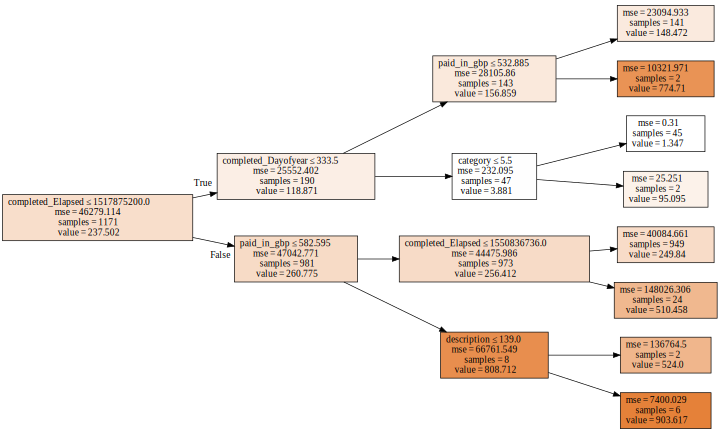

In [61]:
draw_tree(m.estimators_[0], X_train, precision=3)

## 3.3 Bagging

In [62]:
m = RandomForestRegressor(n_estimators = 10, 
                          n_jobs=-1, 
                          random_state = 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 104 ms, sys: 12 ms, total: 116 ms
Wall time: 111 ms
[53.71744053403543, 86.20956856609806, 0.937381246848874, 0.827503521794181]


In [63]:
preds = np.stack([t.predict(X_test) for t in m.estimators_])

In [64]:
preds.shape

(10, 455)

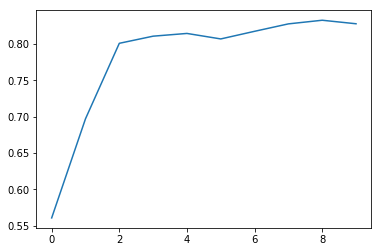

In [65]:
plt.plot([metrics.r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [66]:
m = RandomForestRegressor(n_estimators=4, 
                          n_jobs=-1, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 76 ms, sys: 84 ms, total: 160 ms
Wall time: 107 ms
[65.4435138168636, 90.36706351169306, 0.9070590705047027, 0.8104649084235146]


In [67]:
m = RandomForestRegressor(n_estimators=10, 
                          n_jobs=-1, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 111 ms
[53.71744053403543, 86.20956856609806, 0.937381246848874, 0.827503521794181]


In [68]:
m = RandomForestRegressor(n_estimators=20, 
                          n_jobs=-1, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 240 ms, sys: 0 ns, total: 240 ms
Wall time: 120 ms
[47.8737626761821, 86.14066230110912, 0.9502642218203692, 0.8277791602884075]


In [69]:
m = RandomForestRegressor(n_estimators=40, 
                          n_jobs=-1, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 488 ms, sys: 4 ms, total: 492 ms
Wall time: 233 ms
[43.99050566488942, 85.41332624914689, 0.9580055690519298, 0.8306752047414119]


In [70]:
m = RandomForestRegressor(n_estimators=100, 
                          n_jobs=-1,
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1.21 s, sys: 16 ms, total: 1.22 s
Wall time: 479 ms
[42.092224152273495, 85.75141307417715, 0.961551664664389, 0.8293320939475204]


We see that 40 estimators yields the higest score. Thus, we will progress using 40 as a set value when tuning the next hyperparamters.

## 3.4 Out-of-bag (OOB) score

Our validation set is worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our print_score function below.

In [71]:
m = RandomForestRegressor(n_estimators= 40, 
                          oob_score=True, 
                          n_jobs=-1,
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 492 ms, sys: 0 ns, total: 492 ms
Wall time: 243 ms
[43.99050566488942, 85.4133262491469, 0.9580055690519298, 0.8306752047414119, 0.7145243925690644]


## 3.5 Reducing over-fitting

### 3.5.1 Subsampling

We are now going to experiment with the **fastai** feature `set_rf_samples()`

In [72]:
set_rf_samples(400)

In [73]:
m = RandomForestRegressor(n_estimators= 40, 
                          oob_score=True, 
                          n_jobs=-1, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 208 ms, sys: 4 ms, total: 212 ms
Wall time: 159 ms
[108.78154833335724, 113.7941790700281, 0.7432063594063982, 0.6994550856292621, 0.6060755940535076]


In [74]:
set_rf_samples(800)

In [75]:
m = RandomForestRegressor(n_estimators= 40, 
                          oob_score=True, 
                          n_jobs=-1,
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 308 ms, sys: 4 ms, total: 312 ms
Wall time: 145 ms
[76.9304349410856, 93.71425335813919, 0.8715689101421651, 0.7961641408822228, 0.694941134289963]


In [76]:
set_rf_samples(1600)

In [77]:
m = RandomForestRegressor(n_estimators= 40, 
                          oob_score=True, 
                          n_jobs=-1,
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 452 ms, sys: 12 ms, total: 464 ms
Wall time: 244 ms
[48.805705533331164, 85.1594435266303, 0.9483089941746425, 0.831680311371487, 0.7152609777566257]


In [78]:
set_rf_samples(2400)

In [79]:
m = RandomForestRegressor(n_estimators= 40, 
                          oob_score=True, 
                          n_jobs=-1, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 556 ms, sys: 0 ns, total: 556 ms
Wall time: 242 ms
[31.619327271042962, 81.20251919588219, 0.9783040313954738, 0.8469588237372547, 0.7227069865989565]


Unfortunatley, again due to the poorness of the dataset we cannot assess the impact this hyperparamter has as the best score is achieved by a sub_sample of 2400, which is more than the actual number of rows. 

Hence, we decide not to use this hyperparameter.

In [80]:
reset_rf_samples()

### 3.5.2 Tree building parameters

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

There are less decision rules for each leaf node; simpler models should generalize better
The predictions are made by averaging more rows in the leaf node, resulting in less volatility. We will use the earlier computed `dectree_max_depth` function

In [82]:
t=m.estimators_[0].tree_

In [83]:
dectree_max_depth(t)

33

We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

We will test the following: 1,3,5

In [84]:
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_leaf=1, 
                          n_jobs=-1, 
                          oob_score=True, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 488 ms, sys: 4 ms, total: 492 ms
Wall time: 244 ms
[43.99050566488942, 85.4133262491469, 0.9580055690519298, 0.8306752047414119, 0.7145243925690644]


In [85]:
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_leaf=3, 
                          n_jobs=-1, 
                          oob_score=True,
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

SyntaxError: invalid syntax (<ipython-input-85-882aa5d43a37>, line 2)

In [ ]:
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_leaf=10, 
                          n_jobs=-1, 
                          oob_score=True, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

We see that `min_samples_leaf` = 1 yields the most predictive outcome thus far.
Nevertheless, it reduces our accuracy on predicting the test set by 0.2.

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

In [ ]:
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_leaf=1, 
                          max_features="log2", 
                          n_jobs=-1, 
                          oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

We notice that due to the lack of data our model is generlaising pretty well, but both the score of the training set and of the sample set decreased.

Hence, we conclude that `max_features` is not useful in this instance.

### 3.5.3 Summary - Reducing overfitting. 

Thus far, we have seen how hyperparamter tuning affects our model predictions and understood that the lack of extensive data does influence our predictions. 

- `n_jobs` allows us to run our model faster by deciding how many CPUs we are going to use. 
- `n_estimators` helps us decide the number of trees in our Random Foster.
- `oob_score` allows us to calculate the obb_score.
- `set_rf_sample` allows us to extract a random subset of the training data and form a tree with each subset. This in  turn increases the generalisation of the model's prediction when testing it against the data.
- `min_samples_leaf` helps us decide the depth of our tree. The idea is to create simpler trees, which predict worse when picking them singularly but in turn are less correlated with each other. This again enhances the generalisation capabilities of the model and makes it more accurate when predicting unseen data.
- `max_features` allows us to dictate the feature used at each split of each tree. This is a fairly new hyperparamter, but the results shown by the skelearn documentation [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

Nevertheless, non of these hyperparameter increased the predictions. This is an issue with has to do with the data and its narrow properties.
It might be possible that the prediction would increase exponentially if the same approach is used with a more extensive dataset (ex. 100k+ rows, 100+ columns).

## 3.6 Feature Importance

In [86]:
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_leaf=1, 
                          n_jobs=-1, 
                          oob_score=True, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 468 ms, sys: 16 ms, total: 484 ms
Wall time: 252 ms
[43.99050566488942, 85.4133262491469, 0.9580055690519298, 0.8306752047414119, 0.7145243925690644]


We saw how the model averages predictions across the trees to get an estimate. But how can we know the confidence of the estimate? 

One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the relative confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent.

It's not normally enough to just to know that a model can make accurate predictions - we also want to know how it's making predictions. The most important way to see this is with feature importance.

In [87]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
19,completed_Elapsed,0.350546
12,completed_Dayofyear,0.180858
10,completed_Day,0.172178
1,paid_out_gbp,0.068540
11,completed_Dayofweek,0.046289
0,description,0.040662
2,paid_in_gbp,0.039943
9,completed_Week,0.034128
5,category,0.027842
8,completed_Month,0.013501


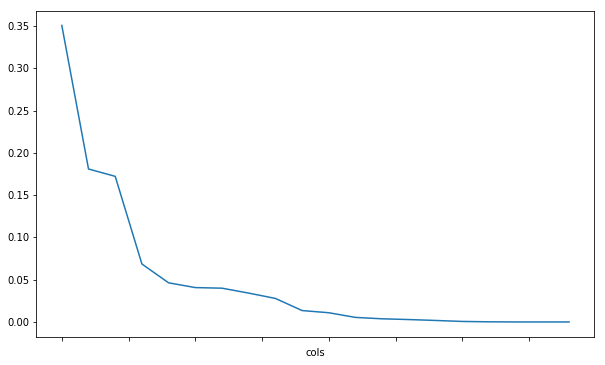

In [88]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [89]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

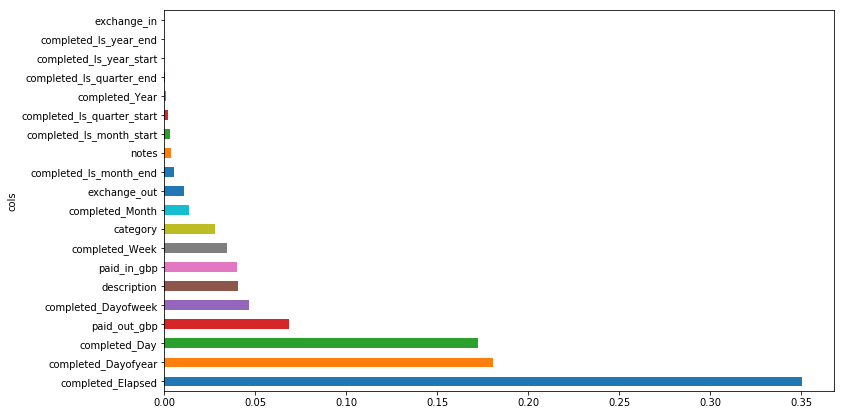

In [90]:
plot_fi(fi);

In [91]:
to_keep = fi[fi.imp>0.0001].cols; len(to_keep)

17

In [92]:
to_keep

19             completed_Elapsed
12           completed_Dayofyear
10                 completed_Day
1                   paid_out_gbp
11           completed_Dayofweek
0                    description
2                    paid_in_gbp
9                 completed_Week
5                       category
8                completed_Month
3                   exchange_out
13        completed_Is_month_end
6                          notes
14      completed_Is_month_start
16    completed_Is_quarter_start
7                 completed_Year
15      completed_Is_quarter_end
Name: cols, dtype: object

In [93]:
df = df_raw[to_keep].copy()

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)

In [95]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1817, 17), (455, 17), (1817,), (455,))

In [96]:
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_leaf=1, 
                          n_jobs=-1, 
                          oob_score=True, 
                          random_state= 1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 488 ms, sys: 8 ms, total: 496 ms
Wall time: 244 ms
[44.201761114098225, 85.96540999349168, 0.9576012611608505, 0.8284792105593345, 0.7120278861509294]


In [97]:
### This project is currently under developement. 